In [14]:
sc

In [15]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely

import rtree
import pandas as pd
import geopandas as gpd

In [16]:
shapefile = 'neighborhoods.geojson'

In [17]:
zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2263))

In [18]:
index = rtree.Rtree()
index.bounds

[1.7976931348623157e+308,
 1.7976931348623157e+308,
 -1.7976931348623157e+308,
 -1.7976931348623157e+308]

In [19]:
for idx, geometry in enumerate(zones.geometry):
    index.insert(idx, geometry.bounds)

In [20]:
index.bounds

[913175.2100462909, 120128.37448660476, 1067382.5266380738, 272844.3751306288]

In [21]:
import pyproj
proj = pyproj.Proj(init='epsg:2263', preserve_units=True)

In [33]:
def zones_rtree(shapeFile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    index = rtree.Rtree()
    neighborhood = gpd.read_file(shapeFile).to_crs(fiona.crs.from_epsg(2263))
    for idx, geometry in enumerate(neighborhood.geometry):
        index.insert(idx, geometry.bounds)
    return (index, neighborhood)

In [40]:
def restaurantMapper(partitions):
    import csv
    import pyproj
    import shapely.geometry as geom
    proj = pyproj.Proj(init='epsg:2263', preserve_units=True)
    index, neighborhood = zones_rtree('neighborhoods.geojson')
    reader = csv.reader(partitions)
    for row in reader:
        if all((row[1], row[2])):
            location = geom.Point(proj(float(row[2]), float(row[1])))
            restaurant_zones = match_zone(location, index, neighborhood)
            if restaurant_zones != -1:
                yield(str(restaurant_zones), 1)

In [41]:
def match_zone(p, index, neighborhood):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if any(map(lambda x: x.contains(p), neighborhood.geometry[idx])):
            return neighborhood['neighborhood'][idx]
    return -1

In [42]:
restaurant_location = sc.textFile('NYCRestaurantsLocations.csv').cache()
restaurant_count = restaurant_location.mapPartitions(restaurantMapper).reduceByKey(lambda a, b: a+b)

In [63]:
output = sorted(restaurant_count.collect())
list(output[0:10])

[('Allerton', 64),
 ('Arden Heights', 18),
 ('Arrochar', 21),
 ('Arverne', 9),
 ('Astoria', 417),
 ('Bath Beach', 149),
 ('Battery Park City', 55),
 ('Bay Ridge', 18),
 ('Bay Terrace', 24),
 ('Bay Terrace, Staten Island', 7)]

In [98]:
def callMapper(partitions):
    import csv
    import pyproj
    import shapely.geometry as geom
    proj = pyproj.Proj(init='epsg:2263', preserve_units=True)
    index, neighborhood = zones_rtree('neighborhoods.geojson')
    reader = csv.reader(partitions)
    next(reader)
    for row in reader:
        #print (row[53])
        location = geom.Point(proj(float(row[52]), float(row[51])))
        zone = match_zone(location, index, neighborhood)
        if zone != -1:
            yield (str(zone), 1)
                                  

In [99]:
call = sc.textFile('new311.csv')
call2 = call.filter(lambda x: not x.startswith('Unique Key') and x != '')
final = call2.mapPartitions(callMapper).reduceByKey(lambda a, b: a+b)

In [100]:
result = final.join(restaurant_count)

In [101]:
fin_result = result.collect()

In [102]:
fin_result

[('Forest Park', (7071, 2)),
 ('Flatiron District', (16158, 54)),
 ('Astoria', (131678, 417)),
 ('West Farms', (35274, 28)),
 ('Graniteville', (16760, 25)),
 ('Queens Village', (72730, 70)),
 ('Port Morris', (11056, 46)),
 ('Morrisania', (55012, 11)),
 ('Edgemere', (10317, 2)),
 ('Pleasant Plains', (3137, 33)),
 ('Floral Park', (18822, 24)),
 ('Midland Beach', (11837, 12)),
 ('Great Kills', (26949, 41)),
 ('Prospect Heights', (36386, 113)),
 ('East Morrisania', (39123, 12)),
 ("Randall's Island", (475, 58)),
 ('Sunnyside', (66724, 136)),
 ('Clason Point', (28188, 9)),
 ('Unionport', (41069, 51)),
 ('Williamsbridge', (70803, 54)),
 ('Van Nest', (32011, 27)),
 ('Gerritsen Beach', (10586, 13)),
 ('Fordham', (227865, 199)),
 ('Roosevelt Island', (2077, 16)),
 ('Brooklyn Heights', (26858, 94)),
 ('Chelsea', (115768, 905)),
 ('Hunts Point', (35118, 40)),
 ('Borough Park', (157647, 195)),
 ('Marine Park', (29467, 40)),
 ('Neponsit', (3369, 16)),
 ('West Village', (76028, 412)),
 ('Grymes Hill

In [129]:
from pandas import DataFrame
data = DataFrame()
data['restaurant'] = list(map(lambda x: x[1][1], fin_result))
data['rat'] = list(map(lambda x: x[1][0], fin_result))

In [132]:
data.head()

,restaurant,rat
0,2,7071
1,54,16158
2,417,131678
3,28,35274
4,25,16760


In [133]:
data.to_csv('rat_restaurant.csv')

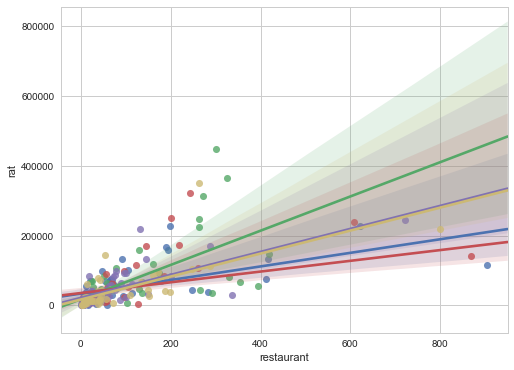

In [134]:
plt.figure(figsize=(8, 6))
bill_size = data[['restaurant', 'rat']]
def data_stream(bs, chunk_size=50):
    for i in range(0, len(bs), chunk_size):
        yield bs[i:i+chunk_size]

for chunk in data_stream(data):
    sns.regplot(x="restaurant", y="rat", data=chunk, x_jitter=.2, fit_reg=True, scatter_kws={"s": 50})